# Metropolis-Hastings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

## 一元分布
让$P(x)=3 e^{-\frac{x^2}{2}}+e^{-\frac{(x-4)^2}{2}}$是我们想要抽样的分布。注意，这是一个非标准化的分布有一个我们可以计算的标准化常数Z，但我们保持它的原样。      
$(Z \approx 10.0261955464)$

In [2]:
P = lambda x: 3 * np.exp(-x*x/2) + np.exp(-(x - 4)**2/2)
Z = 10.0261955464

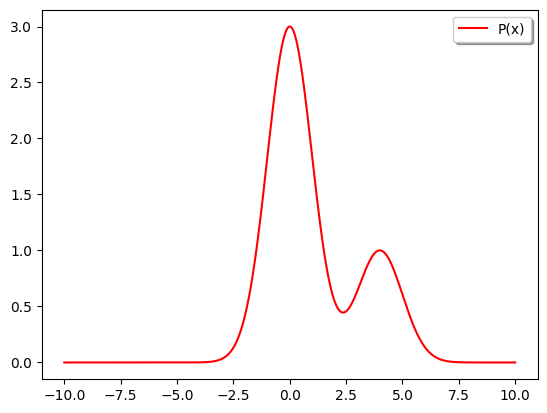

In [3]:
x_vals = np.linspace(-10, 10, 1000)
y_vals = P(x_vals)
plt.figure(1)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

让我们想要近似的函数是$f(x)=x$和$g(x)=\sin (x)$。这两个值为一个非规格化$P$如下:
- $\mathbb{E}[x] \approx 10.02686647165$
- $\mathbb{E}[\sin (x)] \approx-1.15088010640$

In [4]:
f_x = lambda x: x
g_x = lambda x: np.sin(x)
true_expected_fx = 10.02686647165
true_expected_gx = -1.15088010640

**Metropolis Hastings**
对于任何$P(x)$,Metropolis-Hastings算法的过程如下。
- 开始$x_t=x_0$。
- 采样$x_i \sim Q\left(x \mid x_t\right)$
- $A=\min \left(\frac{P\left(x_i\right) Q\left(x_t \mid x_i\right)}{P\left(x_t\right) Q\left(x_i \mid x_t\right)}, 1\right)$
- 采样$k_i \sim \operatorname{Uniform}[0,1]$
  - $\text { if } k_i<A \text { then } x_{t+1}=x_i$
  - $\text { else } x_{t+1}=x_t$

随着$t \rightarrow \infty, x_t$来自于标准化的$P(x)$。马尔可夫链需要一些时间来稳定，这是老化阶段。在下面的代码中，我们将前1000个样本忽略为老化。

在这里我们选择$Q\left(x \mid x_t\right)$作为$\mathcal{N}\left(x_t, 1\right)$实际上等于$Q\left(x_t \mid x\right)$和应该取消，但我已经在代码中添加了它的清晰度。

In [6]:
Q = lambda t1, t0: np.exp(-(t1 - t0)**2/2)/(np.sqrt(2 * np.pi))
x0 = 0
xt = x0
samples = []
for i in range(100000):
    xt_candidate = np.random.normal(xt, 1)
    accept_prob = (P(xt_candidate) * Q(xt, xt_candidate))/(P(xt) * Q(xt_candidate, xt))
    if np.random.uniform(0, 1) < accept_prob:
        xt = xt_candidate
    samples.append(xt)

burn_in = 1000
samples = np.array(samples[burn_in:])
expected_f_x = np.mean(f_x(samples))
expected_g_x = np.mean(g_x(samples))
expected_f_x *= Z
expected_g_x *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_f_x, abs(expected_f_x - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_g_x, abs(expected_g_x - true_expected_gx)))

E[f(x)] = 10.17698, Error = 0.15012
E[g(x)] = -1.15418, Error = 0.00330


计算Metropolis Hastings样本的直方图，并将其与归一化进行比较$P(x)$。很明显，Metropolis Hastings算法从底层的归一化$P(x)$生成样本。

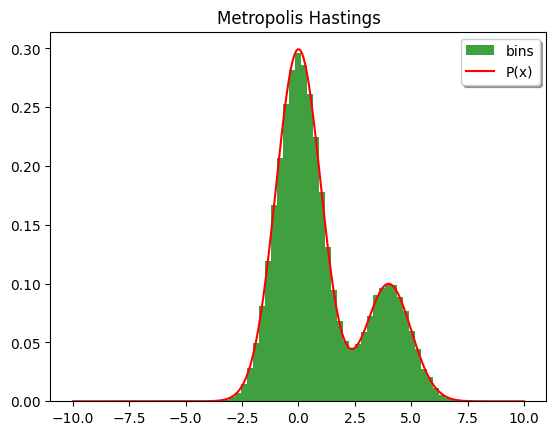

In [8]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, density=True, label='bins')
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

## 二元分布
让$U(\mathbf{z})=\frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2-\log \left(e^{-0.5\left[\frac{\mathbf{z}_{\mathbf{1}}-2}{0.6}\right]}+e^{-0.5\left[\frac{\mathbf{z}_{\mathbf{1}}+2}{0.6}\right]}\right)$和$p(\mathbf{z})=e^{-[U(\mathbf{z})]}$是我们想要采样的非标准化分布。

In [17]:
def density1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

**绘制真实密度**

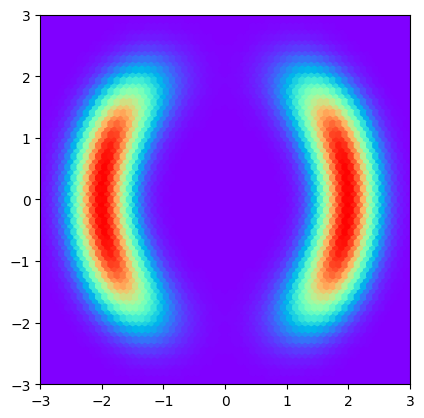

In [18]:
r = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = density1(z)
plt.hexbin(z[:,0], z[:,1], C=q0.squeeze(), cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

建议采用具有多元正态的MH

In [19]:
def metropolis_hastings(target_density, size=500000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [20]:
samples = metropolis_hastings(density1)

100%|██████████| 510000/510000 [01:07<00:00, 7546.25it/s]


**绘制样本的直方图**

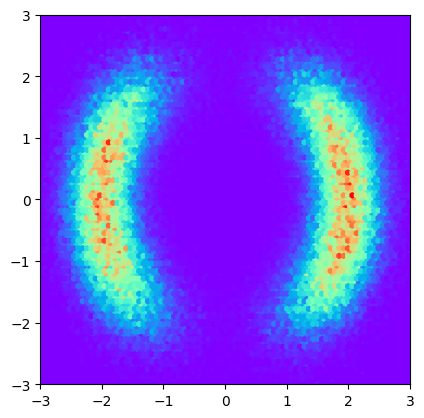

In [21]:
plt.hexbin(samples[:,0], samples[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()
